# CS156 - Assignment 2: The Lending Club
---

**Author**: Snehan Kekre

**Affiliation**: Minerva Schools at KGI

**[Objective](https://seminar.minerva.kgi.edu/app/assignments/46142)**: Build a model that predicts the largest loan amount that will be **successfully** funded for given individual. 

**Note**: The conversion to PDF via `nbconvert` may result in parts of text towards the right of the notebook being cutoff.

URL to the notebook on nbviewer for clarity: [https://tinyurl.com/y6gggkl6](https://tinyurl.com/y6gggkl6)

[https://nbviewer.jupyter.org/github/snehankekre/CS156-Machine-Learning/blob/master/CS156_Assignment_2.ipynb](https://nbviewer.jupyter.org/github/snehankekre/CS156-Machine-Learning/blob/master/CS156_Assignment_2.ipynb)

## Download and Extract the Data

**Source**: https://www.kaggle.com/wordsforthewise/lending-club

**Method**: Use the official [Kaggle API](https://github.com/Kaggle/kaggle-api) to download the data.

In [1]:
!pip install -q kaggle
!mkdir .kaggle

import os
import json
import subprocess

# Kaggle API creds
token = {"username":"snehanrhyme","key":"x-x-x-x-x-x-x-x-x-x-x-x"} # Key excluded for privacy

with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

!mkdir ~/.kaggle/
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Download the data
!kaggle config set -n path -v /content/
!kaggle datasets download -d wordsforthewise/lending-club

- path is now set to: /content/
 97% 600M/618M [00:03<00:00, 172MB/s]
100% 618M/618M [00:04<00:00, 159MB/s]


In [2]:
# Extract the compressed data files
!unzip -q /content/datasets/wordsforthewise/lending-club/lending-club.zip
!gunzip -q accepted_2007_to_2018Q4.csv.gz
!gunzip -q rejected_2007_to_2018Q4.csv.gz

print("The Lending Club data has been extracted to ", os.getcwd())

The Lending Club data has been extracted to  /content


## Import Essential Libraries

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns # Plot styling
from datetime import datetime
import warnings
import re

warnings.simplefilter('ignore')

# Increase the max display limit
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500)

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(12, 8)})

## Load the Data into Memory

In [3]:
%%time
chunksize = 100000

# Read CSV files in chunks of specified size
accept_raw = pd.read_csv('accepted_2007_to_2018Q4.csv',
                         chunksize=chunksize,
                         iterator=True)
 
reject_raw = pd.read_csv('rejected_2007_to_2018Q4.csv',
                         chunksize=chunksize,
                         iterator=True)

# Convert the above TextFileReader objects to Pandas dataframes
accepted_df = pd.concat(accept_raw, ignore_index=True)
rejected_df = pd.concat(reject_raw, ignore_index=True)

CPU times: user 1min 37s, sys: 5.61 s, total: 1min 43s
Wall time: 1min 43s


## Basic Data Exploration

In [4]:
accepted_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [5]:
rejected_df.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [6]:
accepted_df.shape, rejected_df.shape

((2260701, 151), (27648741, 9))

**Note**: The shapes indicate a clear class imbalance problem. The rejected data has an order of magnitude more instances. Rather than synthetically generating data (by either upsampling the minority class or downsampling the majority class), we will accomodate the imbalance via stratified sampling.

That is, we will reflect the same distribution from the original data in both the training and evaluation splits.

In [7]:
# Check the number of null values in each column
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{accepted_df.isnull().sum().sort_values()}")

Sum of null values in each feature:
-----------------------------------
id                                                  0
fico_range_high                                    33
hardship_flag                                      33
revol_bal                                          33
initial_list_status                                33
out_prncp                                          33
out_prncp_inv                                      33
total_pymnt                                        33
total_pymnt_inv                                    33
total_rec_prncp                                    33
total_rec_int                                      33
total_rec_late_fee                                 33
recoveries                                         33
last_pymnt_amnt                                    33
last_fico_range_high                               33
last_fico_range_low                                33
policy_code                                        33
applicatio

**Note**: The columns we are going to include as features incidentally all have $< 50$ null values. Since the number of null values in the columns of interest is $<<$ the number of instances, we will drop all rows containing nulls.

## Data Preprocessing

The Lending Club's Data Dictionary includes definitions for all the data attributes included.

URL: [https://web.archive.org/web/20170227081857/https://resources.lendingclub.com/LCDataDictionary.xlsx](https://web.archive.org/web/20170227081857/https://resources.lendingclub.com/LCDataDictionary.xlsx) 

**Note**: A *Risk Score* column is not explicity included in `accepted_df`. Generally, this would have meant that our model would be severly limited, as risk scores are considered strong signals for loan approval/rejection and loan amounts. Luckily, the provided Data Dictionary states that the risk score of a borrower is their FICO score. We will therefore average a borrower's low and high FICO scores to calculate a proxy for *Risk Score*.

In [0]:
# Fill NA's with the mean FICO score
accepted_df.fico_range_high.fillna(accepted_df.fico_range_high.mean(), inplace=True)

accepted_df.fico_range_low.fillna(accepted_df.fico_range_low.mean(), inplace=True)

accepted_df['Risk_Score'] = accepted_df[['fico_range_high', 'fico_range_low']].mean(axis=1)

Since the reject data contains far fewer columns than the accepted data, it will be the limiting condition for the columns we will include in the final dataframe inputted into our model.

**Columns included**:
- *Loan amount*

- *Debt-to-Income ratio*

- *Zip code*: We create dummy variables with the zip code. After a bit of reading about the format of US zip codes, we decided to include only the first two digits as they specify the region and state. States are included as a column in the accepted data. We hypothesize that this column has an association with the target

- *Employment length*: For simplicity, we simply extract the integer value from the input string and use it as the employment length. We may be limiting our model since every borrower with an employment length of "10+" years is assigned 10 years. Future work could include and sample from a prior or apply more sophisticated imputation techniques

- *Purpose*: We segment borrowers according to the listed purpose of applying for the loan. We make the top 11 purposes into categorical variables and label the rest as "other". This may again be a limitation of our model, and we hope future work will experiment with this feature

- *Risk score*: A "Risk Score" column is not explicity included in the accepted data, unlike the rejected data. Generally, this would have meant that our model would be severly limited, as risk scores are considered strong signals for loan approval/rejection and loan amounts. Luckily, the provided Data Dictionary states that the risk score of a borrower is their FICO score. We will therefore average a borrower's low and high FICO scores to calculate a proxy for Risk Score

**Columns Excluded**:
- *Policy code*: The Data Dictionary indicates that this column will leak information about the target

- All the remaining columns not mentioned above

In [0]:
# Select the subset of columns we are interested in
rejected_df = rejected_df[['Amount Requested', 'Debt-To-Income Ratio', 'Zip Code',
                           'Employment Length', 'Loan Title', 'Risk_Score']]
                           
accepted_df = accepted_df[['loan_amnt', 'dti', 'zip_code', 'emp_length',
                           'purpose', 'Risk_Score']]

pd.options.mode.chained_assignment = None

# Rename the columns so that it will be simple to join the two data frames
rejected_df.columns = ['amount', 'dti', 'zip', 'emp_length', 'purpose', 'risk']
accepted_df.columns = ['amount', 'dti', 'zip', 'emp_length', 'purpose', 'risk']

In [0]:
# Each column contains at most 35 NA's. Drop them according the reasoning provided above
rejected_df.dropna(inplace=True)
accepted_df.dropna(inplace=True)

### Preprocess rejected data:

In [0]:
# Include only first two digits of the zip code
rejected_df['zip'] = rejected_df['zip'].str.extract('(\d+)') # Use simple RegExps
rejected_df['zip'] = rejected_df['zip'].str.slice(0, 2).astype(float)

rejected_df['dti'] = rejected_df['dti'].apply(lambda x: x.strip('%')).astype(float)
rejected_df['emp_length'] = rejected_df['emp_length'].str.extract('(\d+)').astype(float)

# Add a new column with a binary label for accepted/rejected data
rejected_df['accept'] = 0.0

### Preprocess accepted data:

In [0]:
accepted_df['emp_length'] = accepted_df['emp_length'].str.extract('(\d+)').astype(float)
accepted_df['zip'] = accepted_df['zip'].str.extract('(\d+)')
accepted_df['zip'] = accepted_df['zip'].str.slice(0, 2).astype(float)
accepted_df['accept'] = 1.0

### Combine data into a single data frame

In [0]:
all_data = pd.concat([accepted_df, rejected_df])

### Feature engineering with the Purpose column

In [14]:
# Display the top 30 listed purposes
all_data['purpose'].value_counts()[:30]

debt_consolidation         2952678
Debt consolidation         2391342
credit_card                 928176
Other                       829322
Credit card refinancing     678080
other                       676037
home_improvement            338998
Car financing               301511
Home improvement            204832
car                         186538
major_purchase              177278
Medical expenses            159518
small_business              156769
moving                      140938
medical                     139352
Major purchase              127895
Moving and relocation       127095
Home buying                 114972
Business                     99223
house                        68070
vacation                     62113
Vacation                     52848
wedding                      19868
Green loan                   13284
                             12648
renewable_energy             11764
Debt Consolidation            4973
educational                   2246
debt consolidation  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


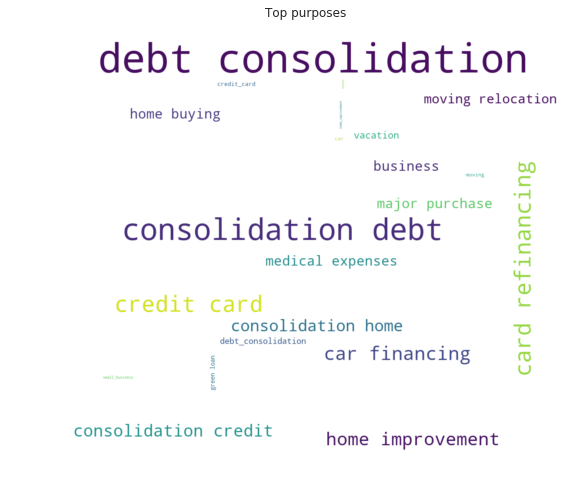

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from wordcloud import WordCloud


text = ' '.join(all_data['purpose'].str.lower().values[-1000:])

# Not the best visualization, but it captures the idea from the cell above
wordcloud = WordCloud(max_font_size=None, stopwords=stop,
                      background_color='white', width=1200,
                      height=1000, max_words=100).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Top purposes')
plt.axis("off")
plt.show()

**Note**: There are duplicated entries in Purpose due to variation in the syntax (a consequence of natural language). We will combine duplicate pairs and triplets into their respective single semantic categories.

In [16]:
def feature_eng_purpose(x):
  purpose = str(x).lower()
  if 'debt' in purpose: return 'debt'
  if 'credit' in purpose: return 'credit_card'
  if 'home' in purpose: return 'home'
  if 'car' in purpose: return 'car'
  if 'medical' in purpose: return 'medical'
  if 'business' in purpose: return 'business'
  if 'moving' in purpose: return 'moving'
  if 'major' in purpose: return 'major_purchases'
  if 'house' in purpose: return 'home'
  if 'vacation' in purpose: return 'vacation'
  if 'wedding' in purpose: return 'wedding'
  return 'other'

purpose_df = all_data['purpose'].apply(feature_eng_purpose)

# Encode them as dummy variables
purpose_dummies = pd.get_dummies(purpose_df, dtype=float)
final_df = pd.concat([all_data, purpose_dummies], axis=1)

# Drop the redundant Purpose column
final_df.drop(['purpose'], axis=1, inplace=True)
final_df.head()

,amount,dti,zip,emp_length,risk,accept,business,car,credit_card,debt,home,major_purchases,medical,moving,other,vacation,wedding
0,3600.0,5.91,19.0,10.0,677.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24700.0,16.06,57.0,10.0,717.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20000.0,10.78,60.0,10.0,697.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35000.0,17.06,7.0,10.0,787.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10400.0,25.37,17.0,3.0,697.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Transform highly skewed features

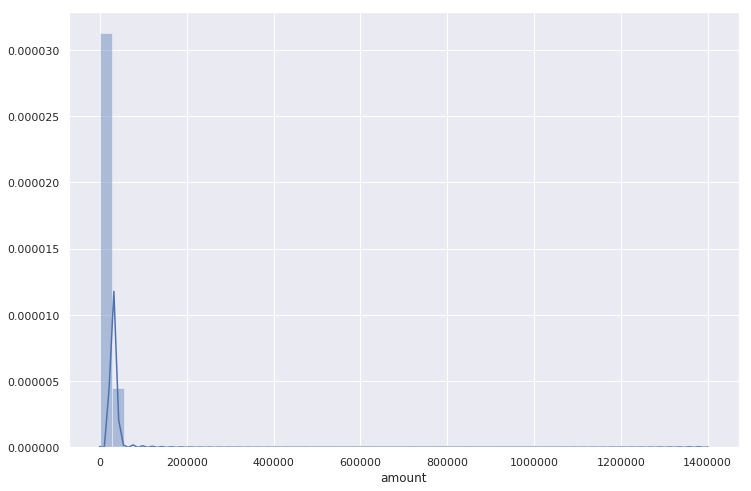

In [17]:
sns.distplot(final_df['amount']);

In [18]:
print("Skew: %f" % final_df['amount'].skew())
print("Kurtosis: %f" % final_df['amount'].kurt())

Skew: 1.541243
Kurtosis: 72.999795


**Note**: Log-transform skewed numeric features

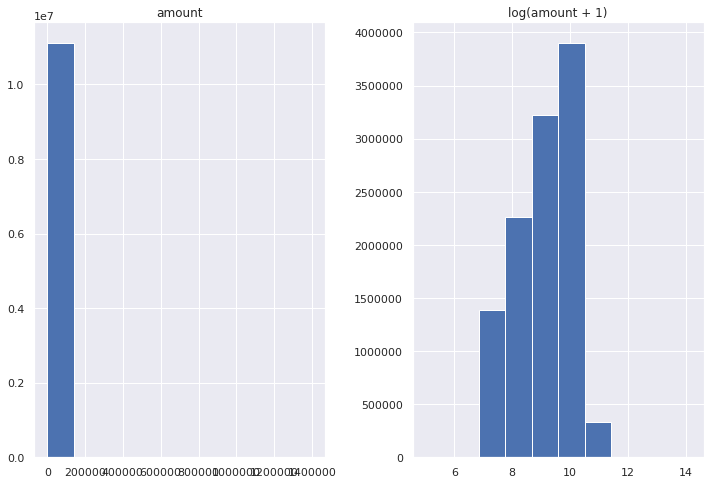

In [19]:
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(12, 8)})

amount = pd.DataFrame({"amount":final_df["amount"], "log(amount + 1)":np.log1p(final_df["amount"])})
amount.hist();

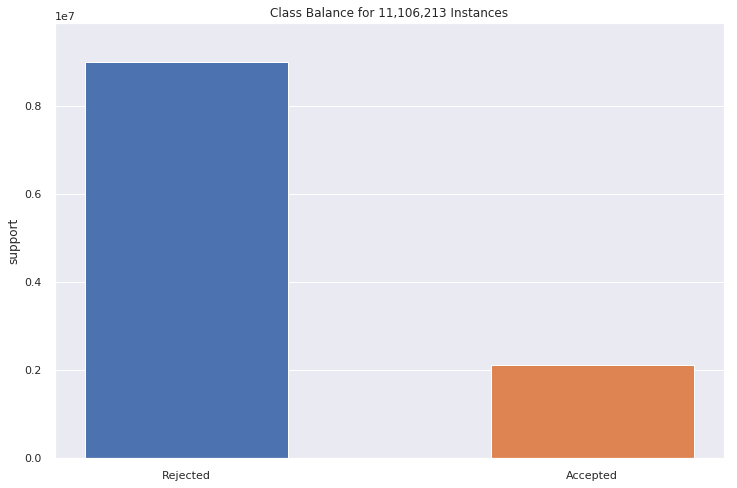

In [20]:
# Visualize class imbalance
from yellowbrick.target import ClassBalance
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(12, 8)})

visualizer = ClassBalance(labels=["Rejected","Accepted"])
visualizer.fit(final_df.accept.values)
visualizer.poof()

In [0]:
# Log transform skewed numeric feature
final_df['amount'] = np.log1p(final_df['amount'])

In [22]:
final_df.head()

,amount,dti,zip,emp_length,risk,accept,business,car,credit_card,debt,home,major_purchases,medical,moving,other,vacation,wedding
0,8.188967,5.91,19.0,10.0,677.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.114599,16.06,57.0,10.0,717.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.903538,10.78,60.0,10.0,697.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.463132,17.06,7.0,10.0,787.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.249657,25.37,17.0,3.0,697.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Create Training and Testing Splits

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder, OrdinalEncoder

final_df.accept = LabelEncoder().fit_transform(final_df.accept)

# Create feature matrix and target vector
X = final_df.loc[:, final_df.columns!='accept']
y = final_df.loc[:, final_df.columns=='accept']

# Stratified sampling to accodmodate target class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Note**: Train/test splits are now class balanced:

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8884970, 16), (8884970, 1), (2221243, 16), (2221243, 1))

## Building and Evaluating the Models

**Note**: We will first build a logistic regression classifier and evaluate it out of sample. Next, we will do the same with a gradient boosted decision tree classifier using XGBoost. We choose the model that has higher F-1 and Accuracy scores.

### Train and test a 5-fold cross-validated logistic regression classifier:

As sklearn does not have GPU support, fitting the Logistic Regression model to our large dataset is going take especially long and be CPU and RAM-intensive:

In [25]:
%%time 

from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import *

# 5-fold CV: the best hyperparameters are selected by the cross-validator
logit_clf = LogisticRegressionCV(cv=5, random_state=0, n_jobs=-1).fit(X_train, y_train)

logit_y_pred = logit_clf.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, logit_y_pred))
print("F-1 score: ", f1_score(y_test, logit_y_pred))

Accuracy score:  0.8887231158409953
F-1 score:  0.6683270019631496
CPU times: user 1min 18s, sys: 16.8 s, total: 1min 35s
Wall time: 24min 8s


[YellowBrick](https://www.scikit-yb.org/en/latest/about.html) is fantastic tool for model introspection and model diagnostics. It extends the scikit-learn API and also wraps around matplotlib

Source: https://www.scikit-yb.org/en/latest/about.html

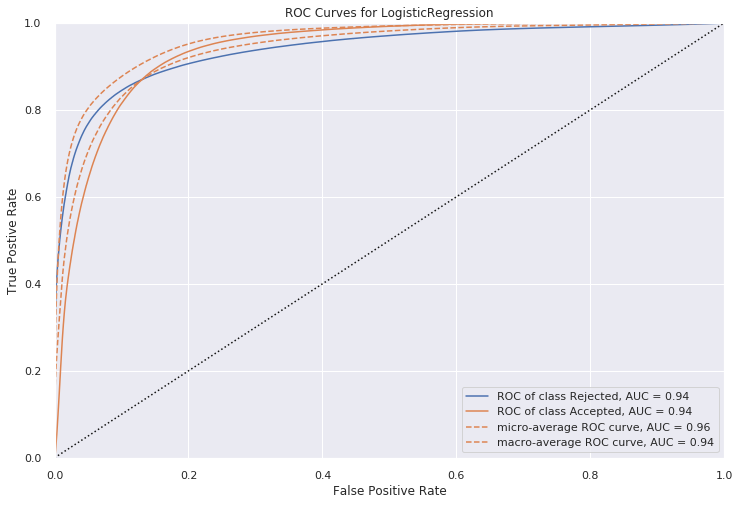

In [28]:
# Visualize the ROCAUC curve
from yellowbrick.classifier import ROCAUC
from sklearn.linear_model import LogisticRegression

visualizer = ROCAUC(logit_clf, classes=["Rejected", "Accepted"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.poof()                

### Train and test a gradient boosted decision tree classifier:

In [27]:
!nvidia-smi

Fri Oct 11 12:53:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [30]:
%%time

# scikit-Learn Wrapper interface for XGBoost. Implementation of the scikit-learn API for XGBoost classification
import xgboost as xgb

clf = xgb.XGBClassifier(learning_rate=0.1,
                        n_estimators=200,
                        min_child_weight=8,
                        scale_pos_weight=1,
                        objective= 'binary:logistic',
                        seed=27,
                        tree_method='gpu_hist',
                        metric='auc')

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

CPU times: user 46 s, sys: 31.8 s, total: 1min 17s
Wall time: 1min 18s


### Evaluation on out-of-sample data

In [31]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

print("XGBoost Accuracy score: ", accuracy_score(y_test, y_pred))
print("XGBoost F-1 score: ", f1_score(y_test, y_pred))

XGBoost Accuracy score:  0.9580811284492512
XGBoost F-1 score:  0.8890837184924001


**Note**: We achieve a higher test accuracy and f-1 score using a gradient boosted decision tree classifier.

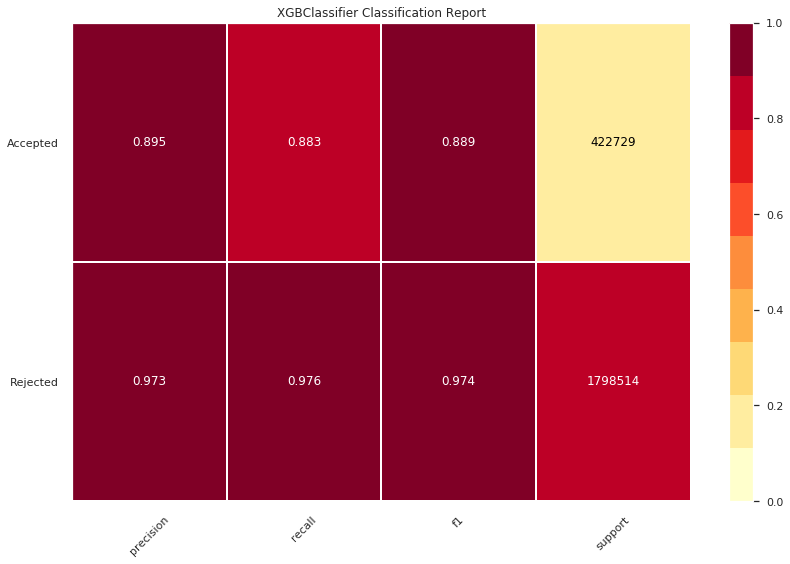

In [32]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(clf, classes=["Rejected", "Accepted"], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()    

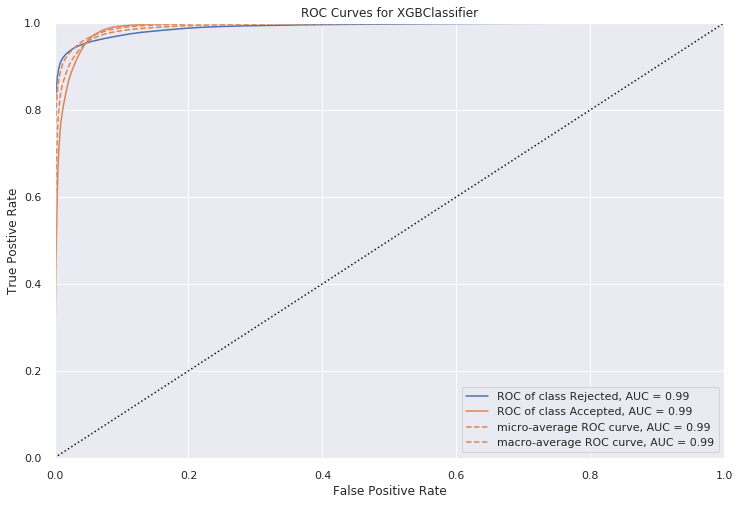

In [33]:
visualizer = ROCAUC(clf, classes=["Rejected", "Accepted"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.poof()                      

### Plot Feature Importances

In [36]:
print(clf.feature_importances_)

[2.5161682e-02 7.7135317e-02 9.7684003e-04 4.5049116e-01 1.3638404e-01
 3.7195090e-02 2.5240632e-02 4.0541567e-02 9.5376685e-02 2.2638758e-04
 0.0000000e+00 0.0000000e+00 2.4741220e-03 1.0879646e-01 0.0000000e+00
 0.0000000e+00]


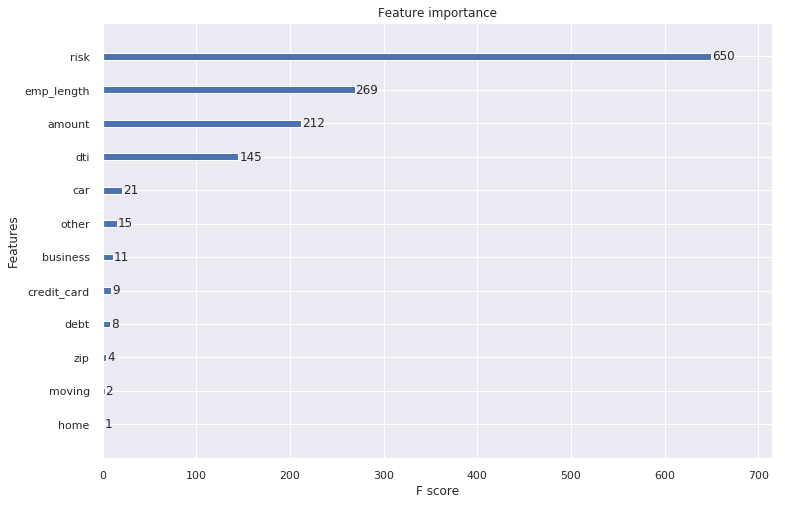

In [38]:
from xgboost import plot_importance
plot_importance(clf);

### Naive optimization

We first create a space of possible loan amounts bounded by the maximum loan amount in our data set. We then iterate through that space, using the current loan value as input to our model. We set a decision threshold at 80%. If our model predicts a greater than 80% probability of acceptance, we return the current loan amount and also specify that there is a non-zero probability of the application being denied.

Future work could instead use a model that creates a decision boundary in the 16-dimensional feature space and uses the threshold to select the maximum possible loan amount. It is ensured to dramatically reduce the run-time complexity of inference.

In [0]:
max_loan_data = final_df.amount.max()
loan_range = np.arange(max_loan_data,  0, -0.000525)

def max_accepted_loan(test):
  for loan in loan_range:
    inputs = test
    inputs.insert(0, "amount", loan)
    accept = clf.predict_proba(inputs)[0][1]
    inputs.drop(["amount"], axis=1, inplace=True)

    if accept >= 0.8 and accept < 1.0:
       print(" Congratulations! We may be able to loan you a maximum amount of $",
             round(np.expm1(loan), 2),"USD\n\n However, there is a", round(1-accept, 2)*100,"% probability that your application will be denied.")
       return
    else:
      pass
  print("Our sincerest apologies. We are unable to provide you a loan at this time. Please call our customer support helpline for further inquires.")

In [126]:
max_accepted_loan(X_test.iloc[0:1, 1:16])

 Congratulations! We may be able to loan you a maximum amount of $ 34988.68 USD

 However, there is a 17.0 % probability that your application will be denied.


In [128]:
max_accepted_loan(X_test.iloc[1:2, 1:16])

 Congratulations! We may be able to loan you a maximum amount of $ 29999.93 USD

 However, there is a 18.0 % probability that your application will be denied.


In [129]:
max_accepted_loan(X_test.iloc[2:3, 1:16])

Our sincerest apologies. We are unable to provide you a loan at this time. Please call our customer support helpline for further inquires.


In [130]:
max_accepted_loan(X_test.iloc[3:4, 1:16])

Our sincerest apologies. We are unable to provide you a loan at this time. Please call our customer support helpline for further inquires.


In [131]:
max_accepted_loan(X_test.iloc[4:5, 1:16])

Our sincerest apologies. We are unable to provide you a loan at this time. Please call our customer support helpline for further inquires.
